In [26]:
import polars as pl
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm, bernoulli, binom

# Read in the data, split on whitespace, and assign column names
df_clean = pl.DataFrame([line.split() for line in open("riverside_2025.txt", "r")], 
                       schema=['treatment', 'earnings1', 'earnings4', 'highschool', 'female', 'age', 'smallchild', 'single'],  # Give meaningful column names
                       orient="row")

# Convert all columns to float (they're strings by default from split())
df_clean = df_clean.with_columns(pl.all().cast(pl.Float64))

print(df_clean)

shape: (5_419, 8)
┌───────────┬───────────┬───────────┬────────────┬────────┬──────┬────────────┬────────┐
│ treatment ┆ earnings1 ┆ earnings4 ┆ highschool ┆ female ┆ age  ┆ smallchild ┆ single │
│ ---       ┆ ---       ┆ ---       ┆ ---        ┆ ---    ┆ ---  ┆ ---        ┆ ---    │
│ f64       ┆ f64       ┆ f64       ┆ f64        ┆ f64    ┆ f64  ┆ f64        ┆ f64    │
╞═══════════╪═══════════╪═══════════╪════════════╪════════╪══════╪════════════╪════════╡
│ 0.0       ┆ 0.264     ┆ 0.0       ┆ 0.0        ┆ 1.0    ┆ 38.0 ┆ 0.0        ┆ 1.0    │
│ 1.0       ┆ 2.4314    ┆ 0.8484    ┆ 1.0        ┆ 1.0    ┆ 34.0 ┆ 0.0        ┆ 1.0    │
│ 1.0       ┆ 1.744     ┆ 0.0       ┆ 1.0        ┆ 0.0    ┆ 38.0 ┆ 0.0        ┆ 1.0    │
│ 1.0       ┆ 0.0       ┆ 22.9053   ┆ 1.0        ┆ 1.0    ┆ 23.0 ┆ 1.0        ┆ 1.0    │
│ 1.0       ┆ 0.0       ┆ 8.1741    ┆ 1.0        ┆ 1.0    ┆ 40.0 ┆ 0.0        ┆ 1.0    │
│ …         ┆ …         ┆ …         ┆ …          ┆ …      ┆ …    ┆ …          ┆ …      │
│ 1

In [37]:
ATE_1 = (df_clean.filter(pl.col("treatment") == 1).select(pl.col("earnings1")).mean() - df_clean.filter(pl.col("treatment") == 0).select(pl.col("earnings1")).mean()).item()

s_0_sq = df_clean.filter(pl.col("treatment") == 0).select(pl.col("earnings1")).var(ddof=1)
s_1_sq = df_clean.filter(pl.col("treatment") == 1).select(pl.col("earnings1")).var(ddof=1)

variance_estimator_1 = (s_0_sq / df_clean.filter(pl.col("treatment") == 0).height + s_1_sq / df_clean.filter(pl.col("treatment") == 1).height).item()

# Calculate homoskedastic variance estimator for earnings1
n_0 = df_clean.filter(pl.col("treatment") == 0).height
n_1 = df_clean.filter(pl.col("treatment") == 1).height
pooled_variance_1 = ((n_0 - 1) * s_0_sq + (n_1 - 1) * s_1_sq) / (n_0 + n_1 - 2)
homoskedastic_variance_1 = pooled_variance_1 * (1/n_0 + 1/n_1)


print(f"ATE: {ATE_1}")
print(f"Variance Estimator: {variance_estimator_1}")
print(f"Homoskedastic Variance Estimator (earnings1): {homoskedastic_variance_1.item()}")


# Calculate z-score for 90% confidence interval (two-tailed test)
# For 90% confidence, alpha = 0.10, so alpha/2 = 0.05
# We need the z-score that leaves 5% in each tail
z_score_90 = norm.ppf(0.95)  # 95th percentile of standard normal distribution

print(f"Our confidence interval for ATE is ATE ± {z_score_90} * sqrt({variance_estimator_1}) so between {ATE_1 - z_score_90 * np.sqrt(variance_estimator_1)} and {ATE_1 + z_score_90 * np.sqrt(variance_estimator_1)}")
print('\n')

ATE_4 = (df_clean.filter(pl.col("treatment") == 1).select(pl.col("earnings4")).mean() - df_clean.filter(pl.col("treatment") == 0).select(pl.col("earnings4")).mean()).item()

s_0_sq = df_clean.filter(pl.col("treatment") == 0).select(pl.col("earnings4")).var(ddof=1)
s_1_sq = df_clean.filter(pl.col("treatment") == 1).select(pl.col("earnings4")).var(ddof=1)

variance_estimator_4 = (s_0_sq / df_clean.filter(pl.col("treatment") == 0).height + s_1_sq / df_clean.filter(pl.col("treatment") == 1).height).item()

# Calculate homoskedastic variance estimator for earnings1
n_0 = df_clean.filter(pl.col("treatment") == 0).height
n_1 = df_clean.filter(pl.col("treatment") == 1).height
pooled_variance_4 = ((n_0 - 1) * s_0_sq + (n_1 - 1) * s_1_sq) / (n_0 + n_1 - 2)
homoskedastic_variance_4 = pooled_variance_4 * (1/n_0 + 1/n_1)

print(f"ATE: {ATE_4}")
print(f"Variance Estimator: {variance_estimator_4}")
print(f"Homoskedastic Variance Estimator (earnings4): {homoskedastic_variance_4.item()}")
# Calculate z-score for 90% confidence interval (two-tailed test)
# For 90% confidence, alpha = 0.10, so alpha/2 = 0.05
# We need the z-score that leaves 5% in each tail
z_score_90 = norm.ppf(0.95)  # 95th percentile of standard normal distribution

print(f"Our confidence interval for ATE is ATE ± {z_score_90} * sqrt({variance_estimator_4}) so between {ATE_4 - z_score_90 * np.sqrt(variance_estimator_4)} and {ATE_4 + z_score_90 * np.sqrt(variance_estimator_4)}")

ATE: 1.13621021012212
Variance Estimator: 0.017993195993492025
Homoskedastic Variance Estimator (earnings1): 0.029031418560452334
Our confidence interval for ATE is ATE ± 1.6448536269514722 * sqrt(0.017993195993492025) so between 0.915571651301482 and 1.3568487689427582


ATE: 1.2323321274413166
Variance Estimator: 0.06190793223363348
Homoskedastic Variance Estimator (earnings4): 0.07866626471664297
Our confidence interval for ATE is ATE ± 1.6448536269514722 * sqrt(0.06190793223363348) so between 0.8230710850596974 and 1.6415931698229358


In [28]:
educ_child = df_clean.filter((pl.col("highschool") == 1) & (pl.col("smallchild") == 1))
educ_nochild = df_clean.filter((pl.col("highschool") == 1) & (pl.col("smallchild") == 0))
noeduc_child = df_clean.filter((pl.col("highschool") == 0) & (pl.col("smallchild") == 1))
noeduc_nochild = df_clean.filter((pl.col("highschool") == 0) & (pl.col("smallchild") == 0))


# Create list of subgroups with their names
subgroups = [
    ("Education + Child", educ_child),
    ("Education + No Child", educ_nochild),
    ("No Education + Child", noeduc_child),
    ("No Education + No Child", noeduc_nochild)
]

# Calculate variance estimator function
def calc_variance_estimator(df_subgroup):
    s_0_sq = df_subgroup.filter(pl.col("treatment") == 0).select(pl.col("earnings1")).var(ddof=1)
    s_1_sq = df_subgroup.filter(pl.col("treatment") == 1).select(pl.col("earnings1")).var(ddof=1)
    n_0 = df_subgroup.filter(pl.col("treatment") == 0).height
    n_1 = df_subgroup.filter(pl.col("treatment") == 1).height
    return (s_0_sq / n_0 + s_1_sq / n_1).item()

# Iterate over subgroups and calculate ATE and variance estimator for each
total_weights = 0
aggregate_ATE = 0
aggregate_variance = 0

for name, subgroup in subgroups:
    ate = (subgroup.filter(pl.col("treatment") == 1).select(pl.col("earnings1")).mean() - 
           subgroup.filter(pl.col("treatment") == 0).select(pl.col("earnings1")).mean()).item()
    
    variance = calc_variance_estimator(subgroup)

    total_weights += (subgroup.height / df_clean.height)
    aggregate_ATE += ate * (subgroup.height / df_clean.height)
    aggregate_variance += variance * (subgroup.height / df_clean.height) ** 2
    
    print(f"{name}: ATE = {ate:.4f}, Variance = {variance:.6f}")

print("\n")
print(f"Aggregate ATE from subgroups: {aggregate_ATE}")
print(f"Aggregate Variance from subgroups: {aggregate_variance}")

Education + Child: ATE = 1.4306, Variance = 0.178407
Education + No Child: ATE = 1.5040, Variance = 0.054664
No Education + Child: ATE = 0.4951, Variance = 0.348776
No Education + No Child: ATE = 0.7640, Variance = 0.028935


Aggregate ATE from subgroups: 1.1258382732841508
Aggregate Variance from subgroups: 0.018068278937550458


In [29]:
educ_child = df_clean.filter((pl.col("highschool") == 1) & (pl.col("smallchild") == 1))
educ_nochild = df_clean.filter((pl.col("highschool") == 1) & (pl.col("smallchild") == 0))
noeduc_child = df_clean.filter((pl.col("highschool") == 0) & (pl.col("smallchild") == 1))
noeduc_nochild = df_clean.filter((pl.col("highschool") == 0) & (pl.col("smallchild") == 0))


# Create list of subgroups with their names
subgroups = [
    ("Education + Child", educ_child),
    ("Education + No Child", educ_nochild),
    ("No Education + Child", noeduc_child),
    ("No Education + No Child", noeduc_nochild)
]

# Calculate variance estimator function
def calc_variance_estimator(df_subgroup):
    s_0_sq = df_subgroup.filter(pl.col("treatment") == 0).select(pl.col("earnings4")).var(ddof=1)
    s_1_sq = df_subgroup.filter(pl.col("treatment") == 1).select(pl.col("earnings4")).var(ddof=1)
    n_0 = df_subgroup.filter(pl.col("treatment") == 0).height
    n_1 = df_subgroup.filter(pl.col("treatment") == 1).height
    return (s_0_sq / n_0 + s_1_sq / n_1).item()

# Iterate over subgroups and calculate ATE and variance estimator for each
total_weights = 0
aggregate_ATE = 0
aggregate_variance = 0

for name, subgroup in subgroups:
    ate = (subgroup.filter(pl.col("treatment") == 1).select(pl.col("earnings4")).mean() - 
           subgroup.filter(pl.col("treatment") == 0).select(pl.col("earnings4")).mean()).item()
    
    variance = calc_variance_estimator(subgroup)

    total_weights += (subgroup.height / df_clean.height)
    aggregate_ATE += ate * (subgroup.height / df_clean.height)
    aggregate_variance += variance * (subgroup.height / df_clean.height) ** 2
    
    print(f"{name}: ATE = {ate:.4f}, Variance = {variance:.6f}")

print("\n")
print(f"Aggregate ATE from subgroups: {aggregate_ATE}")
print(f"Aggregate Variance from subgroups: {aggregate_variance}")

Education + Child: ATE = 2.8341, Variance = 0.846568
Education + No Child: ATE = 1.1731, Variance = 0.213235
No Education + Child: ATE = 0.8861, Variance = 0.823355
No Education + No Child: ATE = 0.9471, Variance = 0.062023


Aggregate ATE from subgroups: 1.2202858059247172
Aggregate Variance from subgroups: 0.060883188540724664


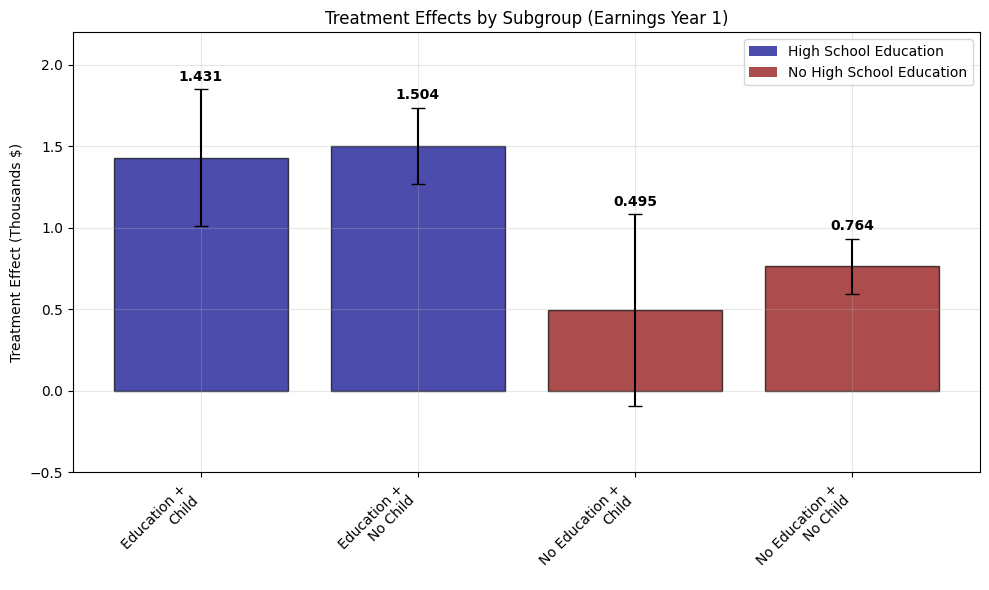

Figures saved as 'ate_comparison.png' and 'subgroup_effects.png'


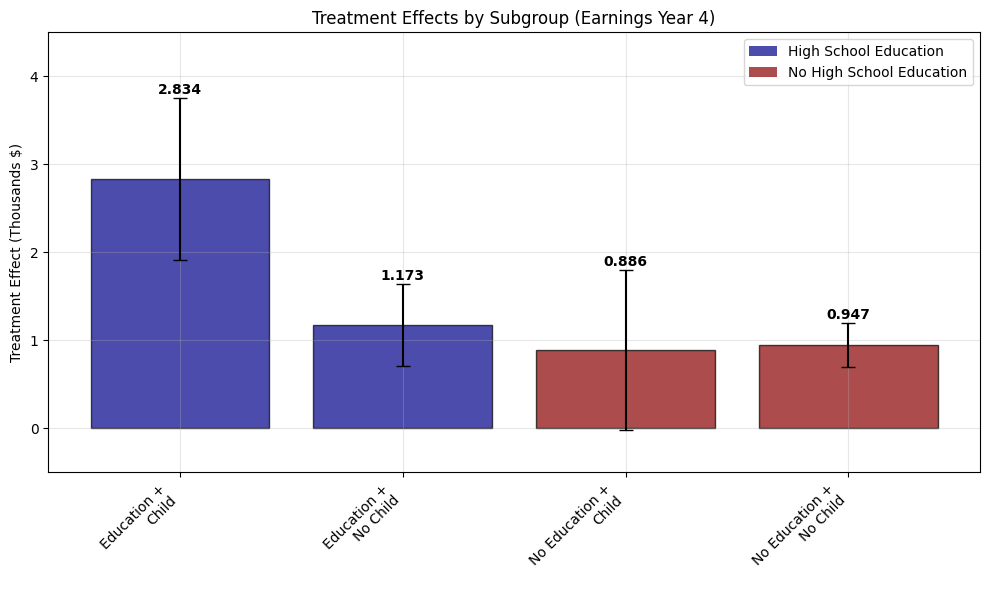

Figure saved as 'subgroup_effects_year4.png'


In [35]:
# Visualization: Subgroup treatment effects
fig, ax = plt.subplots(figsize=(10, 6))

subgroups = ['Education +\nChild', 'Education +\nNo Child', 'No Education +\nChild', 'No Education +\nNo Child']
ate_values = [1.4306, 1.5040, 0.4951, 0.7640]
ate_errors = [np.sqrt(0.1784), np.sqrt(0.0547), np.sqrt(0.3488), np.sqrt(0.0289)]

# Color by education status
colors = ['darkblue', 'darkblue', 'darkred', 'darkred']
bars = ax.bar(subgroups, ate_values, yerr=ate_errors, capsize=5, 
              color=colors, alpha=0.7, edgecolor='black')

ax.set_ylabel('Treatment Effect (Thousands $)')
ax.set_title('Treatment Effects by Subgroup (Earnings Year 1)')
ax.set_ylim(-0.5, 2.2)
ax.grid(True, alpha=0.3)

# Add value labels on bars
for i, (v, e) in enumerate(zip(ate_values, ate_errors)):
    ax.text(i, v + e + 0.05, f'{v:.3f}', ha='center', fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='darkblue', alpha=0.7, label='High School Education'),
                   Patch(facecolor='darkred', alpha=0.7, label='No High School Education')]
ax.legend(handles=legend_elements, loc='upper right')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('subgroup_effects.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figures saved as 'ate_comparison.png' and 'subgroup_effects.png'")

# Visualization: Subgroup treatment effects for earnings4
fig2, ax = plt.subplots(figsize=(10, 6))

subgroups = ['Education +\nChild', 'Education +\nNo Child', 'No Education +\nChild', 'No Education +\nNo Child']
ate_values_4 = [2.8341, 1.1731, 0.8861, 0.9471]  # ATE values for earnings4
ate_errors_4 = [np.sqrt(0.846568), np.sqrt(0.213235), np.sqrt(0.823355), np.sqrt(0.062023)]  # Standard errors

# Color by education status
colors = ['darkblue', 'darkblue', 'darkred', 'darkred']
bars = ax.bar(subgroups, ate_values_4, yerr=ate_errors_4, capsize=5, 
              color=colors, alpha=0.7, edgecolor='black')

ax.set_ylabel('Treatment Effect (Thousands $)')
ax.set_title('Treatment Effects by Subgroup (Earnings Year 4)')
ax.set_ylim(-0.5, 4.5)
ax.grid(True, alpha=0.3)

# Add value labels on bars
for i, (v, e) in enumerate(zip(ate_values_4, ate_errors_4)):
    ax.text(i, v + e + 0.05, f'{v:.3f}', ha='center', fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='darkblue', alpha=0.7, label='High School Education'),
                   Patch(facecolor='darkred', alpha=0.7, label='No High School Education')]
ax.legend(handles=legend_elements, loc='upper right')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('subgroup_effects_year4.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'subgroup_effects_year4.png'")
